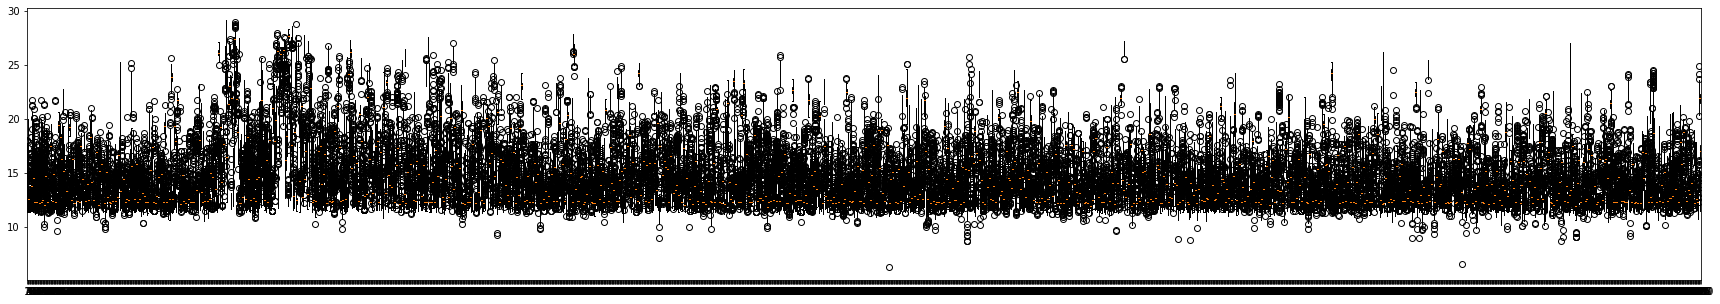

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import dash_bio
import part3

In [2]:
data = part3.data

In [3]:
data.head()

,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I7,A0A075B6J1,A0A075B6J9,A0A075B6K4,A0A075B6K5,A0A075B6P5;P01615,A0A075B6R2,...,Q9Y6C2,Q9Y6E0,Q9Y6E2,Q9Y6G9,Q9Y6L6,Q9Y6N7,Q9Y6R7,Q9Y6Y9,Q9Y6Z7,Cancer
R.FileName,,,,,,,,,,,,,,,,,,,,,
J_D201211_MDIA_P705_SExp01-BGSID-100_R01,14946.335938,44693.898438,5286.701172,2721.810303,6439.688965,4968.654297,9251.992188,40399.160156,7.631951e+04,50205.507812,...,46711.242188,4999.735352,3843.583496,3900.420654,4008.093262,30271.335938,5562199.50,20829.845703,186635.421875,Pancreatic Cancer
J_D201211_MDIA_P705_SExp01-BGSID-101_R01,38555.570312,51684.972656,9045.169922,7985.143555,5580.953125,3497.142578,6626.406738,100954.500000,1.029116e+06,15354.227539,...,37423.011719,32570.783203,16396.248047,5583.424316,2844.958496,17626.980469,3184120.25,19085.271484,125766.781250,Colorectal Cancer
J_D201211_MDIA_P705_SExp01-BGSID-102_R01,4343.331543,46242.109375,7758.438477,6393.914551,2902.563721,3281.517090,7488.952148,15695.381836,4.025498e+04,70995.250000,...,42504.460938,5609.707031,5444.106445,4461.832520,5693.956543,24841.900391,2423431.00,5232.701660,163073.593750,Lung Cancer
J_D201211_MDIA_P705_SExp01-BGSID-103_R01,4416.617676,4498.669922,5079.411133,5620.907227,3928.547607,3783.535645,4335.171387,2919.001953,1.193392e+04,26160.638672,...,42933.371094,5125.121582,5866.069336,8054.897461,6311.884766,32395.267578,1822234.00,5621.607910,242902.843750,Pancreatic Cancer
J_D201211_MDIA_P705_SExp01-BGSID-104_R01,35277.675781,43951.742188,9787.271484,5069.423340,3543.106445,5205.493652,4844.367676,19586.009766,1.528375e+05,58521.871094,...,34184.515625,5825.452637,6959.082520,7264.607422,5692.607422,25756.402344,3612022.00,6194.402832,74033.210938,Breast Cancer


In [ ]:
data.columns

In [13]:
grouped = data.groupby(['Cancer']).mean()

In [14]:
grouped.head()

,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I7,A0A075B6J1,A0A075B6J9,A0A075B6K4,A0A075B6K5,A0A075B6P5;P01615,A0A075B6R2,...,Q9Y696,Q9Y6C2,Q9Y6E0,Q9Y6E2,Q9Y6G9,Q9Y6L6,Q9Y6N7,Q9Y6R7,Q9Y6Y9,Q9Y6Z7
Cancer,,,,,,,,,,,,,,,,,,,,,
Breast Cancer,13187.140263,36317.173757,7822.352153,4667.722373,4698.463450,4937.029588,6789.851263,16415.138160,272284.751118,29005.941706,...,45647.322644,53449.942068,7093.300293,5591.713891,4931.889869,4778.256757,22175.516680,5.230733e+06,10952.167197,164689.472184
Colorectal Cancer,11832.107357,40912.917204,9022.135490,4476.475871,4946.762988,6324.327026,6380.308122,30212.273185,270015.582894,38599.731437,...,54511.457194,44928.764648,7597.077262,5272.359253,5234.250749,4403.393522,19833.795215,4.153629e+06,12292.251904,134257.630078
Healthy,39325.718099,176242.021566,14905.960042,7371.170549,11839.818555,16588.599341,26941.910286,56793.247469,504955.082389,142249.525553,...,44429.198665,54171.375781,8525.523747,5713.459204,5338.725106,5230.565796,29681.205827,4.056345e+06,10943.690967,153609.156510
Lung Cancer,19166.234025,26958.060400,11532.652035,4608.650594,4522.844295,5583.143986,5633.966585,17315.245671,221604.925773,35599.703825,...,37671.809937,56529.430566,7362.302954,6366.620939,5348.059261,4800.621053,19775.517643,3.988329e+06,11516.793481,149480.622819
Pancreatic Cancer,30563.667741,47953.751978,19364.168799,4906.442017,4827.411833,5705.949080,11415.555884,22312.578369,357012.670882,56871.226668,...,41433.378857,65817.966862,7889.486279,5966.448454,4576.721151,6226.448576,21081.106657,6.262894e+06,12906.666292,155801.079036


In [15]:
grouped.reset_index(inplace=True)

In [16]:
melted = grouped.melt(id_vars='Cancer')

In [17]:
melted['HasCancer'] = melted['Cancer']!='Healthy'


In [18]:
del melted['Cancer']

In [19]:
melted

,variable,value,HasCancer
0,A0A075B6H9,13187.140263,True
1,A0A075B6H9,11832.107357,True
2,A0A075B6H9,39325.718099,False
3,A0A075B6H9,19166.234025,True
4,A0A075B6H9,30563.667741,True
...,...,...,...
16375,Q9Y6Z7,134257.630078,True
16376,Q9Y6Z7,153609.156510,False
16377,Q9Y6Z7,149480.622819,True
16378,Q9Y6Z7,155801.079036,True


In [20]:
cancer = melted.groupby(['variable', 'HasCancer']).mean()

In [21]:
cancer = cancer.reset_index()

In [22]:
cancer = cancer.pivot_table(index= 'variable',
                   columns='HasCancer',
                   values='value')

In [23]:
cancer.columns = ['Healthy', 'Cancer']

In [24]:
from math import log2
cancer['L2F'] = (cancer['Healthy'].apply(log2) / cancer['Cancer'].apply(log2))

In [25]:
cancer.L2F

variable
A0A075B6H9    1.082788
A0A075B6I0    1.148331
A0A075B6I1    1.031579
A0A075B6I7    1.051131
A0A075B6J1    1.109004
                ...   
Q9Y6L6        1.006531
Q9Y6N7        1.037320
Q9Y6R7        0.989606
Q9Y6Y9        0.995494
Q9Y6Z7        1.004126
Name: L2F, Length: 2730, dtype: float64

In [ ]:
bdata = data.melt(id_vars='Cancer').groupby(['Cancer', 'variable'])['value'].apply(list)

In [ ]:
cancer.iloc[0]

In [ ]:
from scipy import stats
print(stats.ttest_ind(cancer.iloc[0][0],cancer.iloc[0][1]))

In [ ]:
dash_bio.VolcanoPlot(
    dataframe=part3.data,
)